# Исходные данные

Ознакомить с данными можно в [источнике](https://www.kaggle.com/uciml/student-alcohol-consumption?select=student-por.csv)

Если вкратце, то у вас есть 29 параметров и одна целевая переменная G3

Данные случайным образом разделены на train и test, для train у вас есть ответы, а для test - нет. Необходимо построить такой алгоритм, который будет хорошо предсказывать на test данных.

In [1]:
import pandas as pd

import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import scipy

In [2]:
# Читаем данные

X_train = pd.read_csv('data/train_features_with_answers.csv')
X_test = pd.read_csv('data/X_test.csv')

In [3]:
# Про характеристики прочитайте в источнике

X_train.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,MS,M,NaN,U,LE3,T,1,3,at_home,services,...,yes,yes,4,3,3,2,3,3,0,9
1,GP,M,NaN,R,LE3,T,3,3,teacher,other,...,yes,no,3,3,4,3,5,3,16,12
2,GP,M,15.0,NaN,GT3,T,3,4,other,other,...,yes,no,5,5,1,1,1,5,0,13
3,MS,M,17.0,R,GT3,T,4,3,services,other,...,yes,yes,4,5,5,1,3,2,4,11
4,GP,F,20.0,R,GT3,T,2,1,other,other,...,yes,yes,1,2,3,1,2,2,8,12


In [4]:
X_test.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,MS,M,18,U,GT3,T,4,4,teacher,teacher,...,yes,yes,no,3,2,4,1,4,2,4
1,GP,F,16,U,GT3,A,3,1,services,other,...,yes,yes,no,2,3,3,2,2,4,2
2,MS,F,18,U,GT3,T,4,4,teacher,teacher,...,yes,yes,no,4,3,5,1,2,1,0
3,MS,M,16,R,LE3,A,4,4,at_home,other,...,yes,no,no,5,3,2,1,3,2,5
4,GP,F,15,R,GT3,T,1,1,other,other,...,yes,yes,yes,3,3,4,2,4,5,2


# Визуальный анализ данных (Exploratory Data Analysis) [25 %]

Перед тем, как приступать к построению алгоритмов, необходимо понять данные, с которыми требуется работать. Для этого в подходах к построению алгоритмов машинного обучения выделят специальный этап - Разведочный анализ данных или Exploratory Data Analysis (EDA). EDA в себя включает все те, что касается описания данных: визуализацию, интерпретацию и анализ. 

Прежде всего сделаем визуализацию данных для того, чтобы оценить диапазоны значений и виды их распределений.

Постройте для приведенных ниже характеристик следующие виды графиков:
- Гистограммы;
- Круговые диаграмм;
- Графики;
- Таблицы;
- 3D диаграммы.

Выберите наиболее подходящий тип графика для каждой характеристки. 

__Основной критерий оценивания__ - читаемость и интерпретируемость данных.

## Характеристика: "Sex"

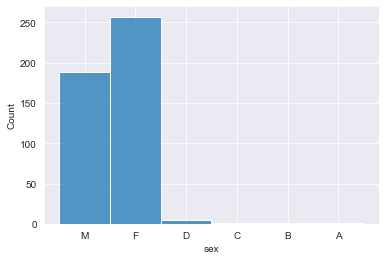

In [5]:
sns.histplot(data=X_train, x='sex')
plt.show()

Помимо логичных категорий **M-male** и **F-female** имеются ошибки в данных в виде D,C,B,A

## Характеристика: "Age"

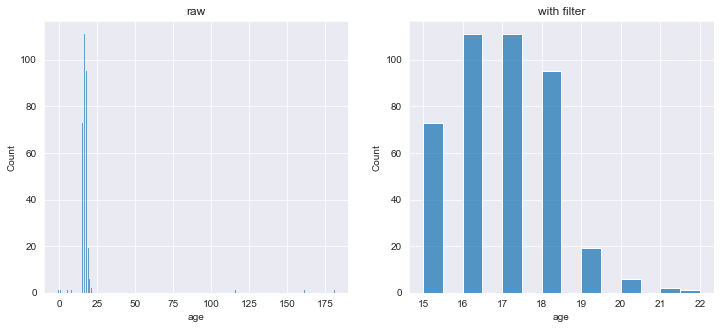

In [6]:
f, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].set_title('raw')
sns.histplot(data=X_train, x='age', ax=ax[0])

ax[1].set_title('with filter')
sns.histplot(data=X_train.query('15<=age<=22'), x='age', ax=ax[1])

plt.show()

В описании датасета на Kaggle указано, что 15≤age≤22, но никак не 150 лет или 0 

## Характеристика: "Weekly study time"

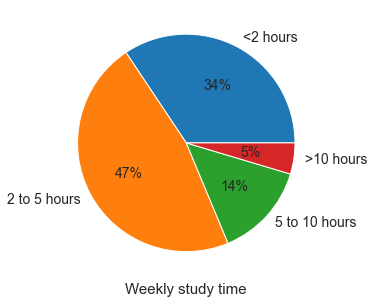

In [7]:
study_data = X_train.groupby('studytime', as_index=False).count()[['studytime', 'school']]
study_data = study_data.replace({'studytime': {1:'<2 hours', 
                                               2:'2 to 5 hours',
                                               3:'5 to 10 hours',
                                               4:'>10 hours'}})

f, ax = plt.subplots(figsize=(5, 5))
plt.pie(x=study_data['school'], autopct='%1.0f%%', labels=study_data['studytime'], textprops={'fontsize': 14})
plt.xlabel('Weekly study time', fontsize=15)

plt.show()

Как видно из графика: моду распределия представляет 2-5 часов обучения

## Характеристика: "Romantic Relationship"

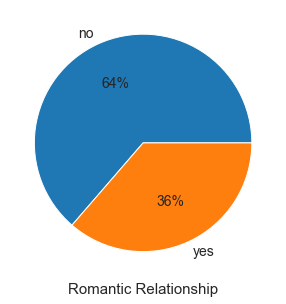

In [8]:
romantic_data = X_train.groupby('romantic', as_index=False).count()[['romantic', 'school']]

f, ax = plt.subplots(figsize=(5, 5))
plt.pie(x=romantic_data['school'], autopct='%1.0f%%', labels=romantic_data['romantic'], textprops={'fontsize': 14})
plt.xlabel('Romantic Relationship', fontsize=15)

plt.show()

## Характеристика: "Alcohol Consumption"

Объединим workday alcohol consumption и weekend alcohol consumption в один признак

In [9]:
X_train['Alc'] = X_train['Dalc'] + X_train['Walc']
X_test['Alc'] = X_test['Dalc'] + X_test['Walc']

Text(0.5, 0, 'Weekly alcohol consumption')

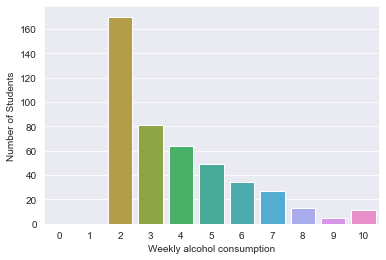

In [10]:
f, ax = plt.subplots(figsize=(6, 4))

l = []
for i in np.arange(0, 11):
    l.append(len(X_train[X_train.Alc == i]))
ax = sns.barplot(x = np.arange(0, 11), y = l)

plt.ylabel('Number of Students')
plt.xlabel('Weekly alcohol consumption')

Большинство учеников редко выпивают

## Целевая зависимость: "G3" (Final Grade)

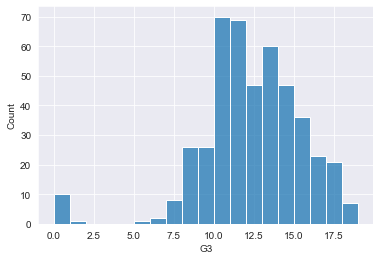

In [11]:
sns.histplot(data=X_train, x='G3')
plt.show()

## Прочие характеристики

Прочитайте описание данных на [сайте](https://www.kaggle.com/uciml/student-alcohol-consumption) и подумайте, какие еще характеристики было бы полезно проанализировать. Постройте соответсвующие графики для выбранных характеристик.

Постройте графики еще для минимум 2 характеристик: числовая и категориальная. 

## Хакартеристика: "number of school absences"

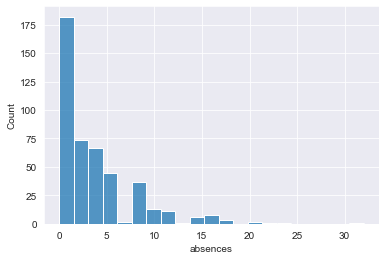

In [12]:
sns.histplot(data=X_train, x='absences')
plt.show()

## Хакартеристика: "extra-curricular activities"

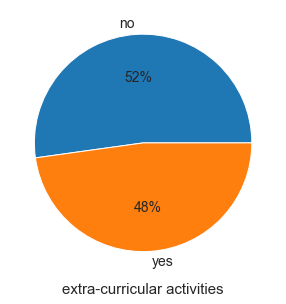

In [13]:
romantic_data = X_train.groupby('activities', as_index=False).count()[['activities', 'school']]

f, ax = plt.subplots(figsize=(5, 5))
plt.pie(x=romantic_data['school'], autopct='%1.0f%%', labels=romantic_data['activities'], textprops={'fontsize': 14})
plt.xlabel('extra-curricular activities', fontsize=15)
plt.show()

## Корреляция признаков

Для того, чтобы быстро получить оценку о взаимосвязи признаков целесообразно построить матрицу их корреляции. Постройте матрицу корреляции.

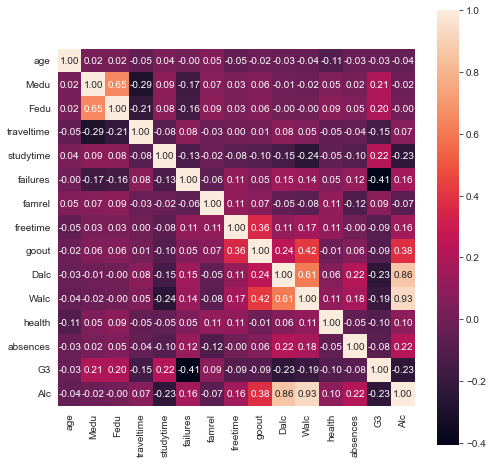

In [14]:
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(X_train.corr(), 
            square=True, 
            annot = True, 
            fmt = ".2f")
plt.show()

## Диапазон значений характеристик

Посчитайте число уникальных значений для каждого признака и сравните их между собой.

In [15]:
uniques = X_train.nunique().sort_values(ascending=False)
uniques

absences      22
G3            17
age           16
Alc            9
sex            6
Fedu           5
Medu           5
Mjob           5
Fjob           5
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
failures       4
studytime      4
traveltime     4
reason         4
guardian       3
famsize        2
Pstatus        2
address        2
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
school         2
dtype: int64

## Сравнение:

* Значительную часть признаков бинарные и принимают только 2 значения, к примеру internet - yes/no, address - U/R;
* Также есть категориальные признаки, которые являются диапазонами числовых переменных, к примеру traveltime, studytime;
* Целевая переменная G3 представлена широким диапазоном значений, также как и с absences;
* Переменная age имеет 16 уникальных значений, хотя меняетя с шагом 1 в пределах от 15 до 22 включительно (т.е. должна иметь 8 уникальных значений). Тоже самое с переменной age, у которой должно быть 2 варианта.


# Предобработка данных [25%]

Теперь перейдем к подготовке данных для моделей машинного обучения. Не все из описанного ниже нужно делать. Подумайте.

## Найдите и исправьте ошибки в данных

In [16]:
# Уберем все нередопустимые значения в переменной sex, при этом оставив наблюдения
X_train.loc[~X_train['sex'].isin(['M', 'F']), 'sex'] = np.nan
print(f"Num unique sex values after: {X_train['sex'].nunique()}")

# согласно данным на Kaggle возраст респондентов ограничен 15-22 годами
X_train.loc[((22<X_train['age']) | (X_train['age']<15)), 'age'] = np.nan
print(f"Num unique age values after: {X_train['age'].nunique()}")


Num unique sex values after: 2
Num unique age values after: 8


## Удалите скоррелированные данные

In [17]:
# Walc и Dalc значительно коррелируют между собой. Оставим только Alc, удалив их.
# Исходя из тех же соображений уберем Fedu


X_train['Pedu'] = X_train['Fedu'] + X_train['Medu']
X_test['Pedu'] = X_test['Fedu'] + X_test['Medu']

X_train.drop(['Walc', 'Dalc', 'Fedu', 'Medu'], 1, inplace=True)
X_test.drop(['Walc', 'Dalc', 'Fedu', 'Medu'], 1, inplace=True)

## Заполните пропуски в данных

Заполнить пропуски в данных можно следующими способами:
- Заполнить нулями
- Выбросить данные с нулями (не рекомендуется)
- Заполнить средним для данного параметра
- Заполнить наиболее соответствующим данному прецеденту

In [18]:
# Разделение на численные и категориальные переменные
y_train = X_train['G3']

cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).drop('G3',1).columns


#### Заполним пропуски средним для числовых и модой для категориальных переменных

In [19]:
num_fill_value = X_train[num_cols].mean()
X_train[num_cols] = X_train[num_cols].fillna(num_fill_value)
X_test[num_cols] = X_test[num_cols].fillna(num_fill_value)

cat_fill_value = X_train[cat_cols].mode().iloc[0]
X_train[cat_cols] = X_train[cat_cols].fillna(cat_fill_value)
X_test[cat_cols] = X_test[cat_cols].fillna(cat_fill_value)

## Сделайте признаки категориальными

In [20]:
# Кодируем категориальные 
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10)
enc.fit(X_train[cat_cols]) 

X_train[cat_cols] = enc.transform(X_train[cat_cols])
X_test[cat_cols] = enc.transform(X_test[cat_cols])

## Придумайте сложные признаки

Сложные признаки - это комбинации существующих (линейных или нелинейных).
Это нужно для того, чтобы самостоятельно добавить нелинейность в алгоритм.

Приведите не менее двух признаков.

#### 1 признак: беспечность - carelessness

Чем больше подросток ходит гулять с друзьями, пропускает занятия и ходит гулять с друзьями, тем он более беспечный/беззаботный

In [21]:
X_train['carelessness'] = X_train['Alc']*X_train['absences']*X_train['goout']
X_test['carelessness'] = X_test['Alc']*X_test['absences']*X_test['goout']


c = scipy.stats.pearsonr(X_train['carelessness'], y_train)
print(f"Correlation with G3: {c}")

Correlation with G3: (-0.13675233835034314, 0.003505772951892342)


#### 2 признак: cleverness 
Чем больше ученик учится, и чем меньше ходит гулять 

In [22]:
X_train['cleverness'] = X_train['studytime']/(X_train['goout'])
X_test['cleverness'] = X_test['studytime']/(X_test['goout'])

c = scipy.stats.pearsonr(X_train['cleverness'], y_train)
print(f"Correlation with G3: {c}")

Correlation with G3: (0.15201031276497573, 0.0011585369670895724)


#### 3 признак: семейное благополучие - parents_wellbeing

In [23]:
X_train['parents_wellbeing'] = X_train['famrel']*(1+X_train['Pedu'])
X_test['parents_wellbeing'] = X_test['famrel']*(1+X_test['Pedu'])

c = scipy.stats.pearsonr(X_train['parents_wellbeing'], y_train)
print(f"Correlation with G3: {c}")

Correlation with G3: (0.2171022168474637, 3.0280809035560993e-06)


#### Визуализируем зависимость целевой переменной от новых признаков

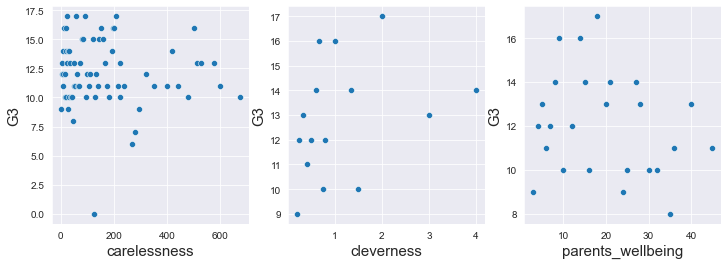

In [24]:
f, ax = plt.subplots(ncols=3, figsize=(12, 4))

k=0
for i in ['carelessness', 'cleverness', 'parents_wellbeing']: 
    a = X_train.groupby(i, as_index=False).mean()
    sns.scatterplot(x=a[i], y=y_train, ax=ax[k])
    #sns.jointplot(x=a[i], y=y_train, ax=ax[0, k])
    ax[k].set_xlabel(i, fontsize=15)
    ax[k].set_ylabel('G3', fontsize=15)
    k+=1


In [25]:
# Scale числовых значений с средним 0 и стандартным отклонением 1
from sklearn.preprocessing import StandardScaler

# обновим список столбцов
num_cols = X_train.select_dtypes(include=['int64', 'float64']).drop('G3',1).columns

scaler = StandardScaler()
scaler.fit(X_train[num_cols])

X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

## Балансировка классов

В качестве методов для балансировки классов можно рассмотреть следующее: 
- Выкинуть те, которых много.
- Дублировать примеры для случаев, которых мало (наиболее адекватный).
- Увеличить lr (вес) тех случаев, которых мало.

#### Будем решать задачу регрессии, поэтому баланс классов не требуется

# Стратегия валидации [10%]

Итак, у вас есть данные для обучения и данные, на которых необходимо сделать предсказание. Для оценки точности необходимо проводить валидацию (так как мало данных, можно проводить кросс валидацию).
Валидацию проще всего реализовать методами sklearn, например:
- KFold
- ShuffleSplit
- StratifiedKFold
- StratifiedShuffleSplit
- GroupKFold
- GroupShuffleSplit

## Разделите данные и объясните выбор стратегии

#### Выберем стратегию *StratifiedShuffleSplit* чтобы получить множества случайных перестановок, при этом сохранив баланс классов в train и test фолдах т.к. для Adversarial Validation стоит задача классификации регрессии

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

## Состязательная валидация (Adversarial Validation) [+30% к ДЗ]

Данная стратегия часто применяется в соревнованиях по машинному обучению. Так как проверить свой алгоритм возможно только на заданном тренировочном наборе данных, а результат требуется к набору, для которого нет ответов, то выбирают следующий подход:
- оценить степень схожести тренировочных и тестовых данных;
- составить валидацию из тех тренировочных данных, которые больше похожи на тестовые.

Алгоритм реализации AV:
1. Удаляем ответы из тренировочных данных.
2. Добавляем специальные метки (```is_test```) для классов: тренировочные данные и тестовые.
То есть у тестовых данных будет значение ```is_test = 1```, а у тренировочных ```is_test = 0```.
4. Учим алгоритм классификации предсказывать заданную метку ```is_test```.
5. Делим тренировочные данные на N частей и проводим кросс-валидацию.

Обучаем N алгоритмов классификации: каждый обучается на всех тестовых данных и на N-1 наборах тренировочных. Предсказываем на 1 тренировочном наборе.

6. Для каждого элемента в выборке предсказываем вероятность принадлежности класса и сортируем тренировочные данные по вероятности принадлежности тестовой выборке.
7. Выделяем заданное число данных в валидацию.
8. Обучаемся для итогового предсказания на всех данных.

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
# копируем чтобы составить обучающий датасет для Adversarial Validation модели
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

X_train_copy.drop('G3', 1, inplace=True)
# проставляем таргет
X_train_copy['is_test'] = 0
X_test_copy['is_test'] = 1

# размер выборки каждого класса
minor_class = len(X_test_copy)
major_class = len(X_train_copy)

# увеличим миноритарный класс до среднего значения и сократим мажоритарный таким же образом
s = int((major_class+minor_class)/2)
X_advers = pd.concat((X_train_copy.sample(s),
                      X_test_copy.sample(s, replace=True)), 0)

# перемешаем датасет
#X_advers = X_advers.sample(frac=1).reset_index(drop=True)

print(f"Примеров класса is_test=1: {len(X_advers[X_advers['is_test']==1])}")
print(f"Примеров класса is_test=0: {len(X_advers[X_advers['is_test']==0])}")


X = np.array(X_advers.drop('is_test', 1))
y = np.array(X_advers['is_test'])

Примеров класса is_test=1: 324
Примеров класса is_test=0: 324


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_auc_score

# в качестве модели импользуем логистическую регрессию
lr = LogisticRegression()
mse_score = []

# cros val
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    lr.fit(X[train_index], y[train_index])
    y_pred_lr = lr.predict(X[test_index])
    mse_score.append(mean_squared_error(y_pred_lr, y[test_index]))

print(np.mean(mse_score))

0.4604938271604938


In [30]:
try:
    X_train = X_train.drop('is_test_proba',1)
except:
    pass
    
# is_test_proba - оценка схожести данных X_test на данные для сабмита
X_train['is_test_proba'] = 100*lr.predict_proba(np.array(X_train.drop('G3',1)))[:, 1]

In [31]:
val_size = int(X_train['is_test_proba'].quantile(0.8))
print(f"Возьмем в валидацию 20% тренировочной выборки максимально похожей на данные для сабмита")

# восстановим тагрет
X_train['G3'] = y_train

Возьмем в валидацию 20% тренировочной выборки максимально похожей на данные для сабмита


In [32]:
# в качестве тестовых данных возьмём наиболее похожие на данные из сабмита
X_test_new = X_train.query("is_test_proba >= @val_size").drop(['is_test_proba', 'G3'], 1)
y_test_new = X_train.query("is_test_proba >= @val_size")['G3']

X_train_new = X_train.query("is_test_proba < @val_size").drop(['is_test_proba', 'G3'], 1)
y_train_new = X_train.query("is_test_proba < @val_size")['G3']

# Обучение алгоритма

Целевая переменная принимает дискретные значения [0; 20], поэтому вы можете поставить как задачу классификации, так и задачу регрессии.

!Не забудьте про оптимизацию параметров алгоритмов, у вас же уже есть данные для валидации.

## KNN [20%]

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings
filterwarnings('ignore')

params = {"n_neighbors": np.arange(1, 10), "p": [1, 2]}

knn = GridSearchCV(KNeighborsRegressor(), cv=3, param_grid=params)

knn.fit(X_train_new, y_train_new)
y_pred_knn = knn.predict(X_test_new)

mse_score = mean_squared_error(y_pred_knn, y_test_new)
print(mse_score)

5.569645732689211


## Регрессия [20%]

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV

lr = LinearRegression()

lr.fit(X_train_new, y_train_new)
y_pred_lr = lr.predict(X_test_new)

mse_score=mean_squared_error(y_pred_lr, y_test_new)

print(mse_score)

5.5401425495058785


#### Усредним прогноз двух алгоритмов

In [35]:
compose_pred = (y_pred_lr+y_pred_knn)/2
compose_pred = compose_pred.astype(int)
mean_squared_error(compose_pred, y_test_new)

5.217391304347826

Как видно, MSE при композиции двух моделей ниже

# Сделайте итоговое предсказание

Решением является данный ноутбук + .csv файл с предсказанием. Пример формата файла, который должен у вас получится приведен в ```data/sample_submission.csv```.

Значения предсказаний должны быть целочисленными. Проверка будет точности будет по MSE.

In [93]:
y_subm_knn = knn.predict(np.array(X_test))
y_subm_knn = y_subm_knn

y_subm_lr = lr.predict(np.array(X_test))
y_subm_lr = y_subm_lr

result_submission = (y_subm_knn+y_subm_lr)/2
result_submission = result_submission.astype(int)

In [94]:
# Для jupyter notebook

submission = pd.read_csv('data/sample_submission.csv', index_col='id')
submission['G3'] = result_submission # ваше предсказание
submission.to_csv('data/submission.csv')#index=False??